In [11]:
#!/usr/bin/python
# -*- coding:utf-8 -*-

import os

# from tensorflow.python.platform import gfile
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf

from tf import visualization


def load_model_and_predict(model_dir, model_name, input_dict, output_names,
                           model_suffix=".pb", scope="", var_suffix=":0"):
    sess = tf.compat.v1.Session()
    with tf.gfile.GFile(os.path.join(model_dir, model_name + model_suffix), 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name=model_name)
    sess.run(tf.compat.v1.global_variables_initializer())

    # for tensor in tf.contrib.graph_editor.get_tensors(tf.compat.v1.get_default_graph()):
    #     print(tensor, tensor.shape)
    # name_scope = sess.graph.get_name_scope()
    # collection_keys = sess.graph.get_all_collection_keys()
    # operations = sess.graph.get_operations()
    # print("name_scope: {}".format(name_scope))
    # print("collection_keys: {}".format(collection_keys))
    # print("operations: {}".format(operations))

    feed_dict = {}
    ops = []
    for input_name in input_dict:
        name = ((scope + "/" + input_name) if scope else input_name) + var_suffix
        input_tensor = sess.graph.get_tensor_by_name(name)
        feed_dict[input_tensor] = input_dict[input_name]
    for output_name in output_names:
        name = ((scope + "/" + output_name) if scope else output_name) + var_suffix
        output_tensor = sess.graph.get_tensor_by_name(name)
        ops.append(output_tensor)
    # print("ops: {}".format(ops))
    # print("feed_dict: {}".format(feed_dict))
    res = sess.run(ops, feed_dict=feed_dict)
    # res = sess.run(output_names, feed_dict=input_dict)
    return res


In [12]:

def label_image(model_dir, img):
    model_name = "tensorflow_inception_graph"
    with open(os.path.join(model_dir, "imagenet_comp_graph_label_strings.txt"), "r") as f:
        labels = f.readlines()
    # print(labels, len(labels))

    input_dict = {"input": np.reshape(img, [1] + list(img.shape))}
    output_names = ["output"]
    res = load_model_and_predict(model_dir, model_name, input_dict, output_names, scope=model_name)
    print("===================================output===================================")
    max_idx = np.argmax(res[0][0])
    print(res, res[0].shape, max_idx)
    print(labels[max_idx], res[0][0][max_idx] * 100)


def detect_image(model_dir, img):
    model_name = "ssd_mobilenet_v1_android_export"
    with open(os.path.join(model_dir, "coco_labels_list.txt"), "r") as f:
        labels = f.readlines()
    # print(labels, len(labels))

    input_dict = {"image_tensor": np.reshape(img, [1] + list(img.shape))}
    output_names = ["detection_boxes", "detection_classes", "detection_scores", "num_detections"]
    res = load_model_and_predict(model_dir, model_name, input_dict, output_names, scope=model_name)
    print("===================================output===================================")
    # [print(r, r.shape) for r in res]
    num_detections = int(res[3])
    detection_boxes = res[0][0][:num_detections]
    detection_classes = res[1][0][:num_detections]
    detection_labels = np.array(labels)[list(map(lambda c: int(c), detection_classes))]
    detection_scores = res[2][0][:num_detections]
    print("detection_boxes: {}".format(detection_boxes))
    print("detection_classes: {}".format(detection_classes))
    print("detection_labels: {}".format(detection_labels))
    print("detection_scores: {}".format(detection_scores))
    print("num_detections: {}".format(num_detections))
    return detection_labels, detection_classes, detection_scores, detection_boxes


===================================output===================================
detection_boxes: [[0.24850914 0.3027202  0.90021884 0.4294266 ]
 [0.3204083  0.62438136 0.8059317  0.94416994]
 [0.62529194 0.11110308 0.818383   0.3186144 ]]
detection_classes: [ 1. 19. 18.]
detection_labels: ['person\n' 'horse\n' 'dog\n']
detection_scores: [0.9815985 0.7257537 0.7046938]
num_detections: 3


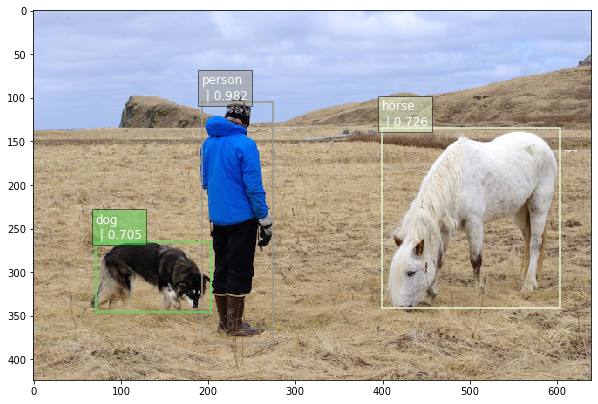

In [13]:

def main():
    cur_path = os.getcwd()
    root_path = os.path.dirname(cur_path)
    model_dir = os.path.join(root_path, os.path.join("data", "model"))
    img_dir = os.path.join(root_path, os.path.join("data", "image"))
    image_names = sorted(os.listdir(img_dir))
    # print(image_names)
    img = mpimg.imread(os.path.join(img_dir, image_names[-2]))
    
    # label_image(model_dir, img)
    detection_labels, detection_classes, detection_scores, detection_boxes = detect_image(model_dir, img)
    visualization.plt_bboxes(img, detection_labels, detection_classes, detection_scores, detection_boxes)


if __name__ == "__main__":
    main()
